In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
warnings.filterwarnings("ignore")



# Any results you write to the current directory are saved as output.

In [2]:
bit_data=pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv")
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Close"].mean()

In [3]:
data

date
2011-12-31       4.482500
2012-01-01       4.806667
2012-01-02       5.000000
2012-01-03       5.252500
2012-01-04       5.223333
                 ...     
2020-04-18    7154.182630
2020-04-19    7167.088857
2020-04-20    7050.542267
2020-04-21    6867.164541
2020-04-22    6850.600000
Name: Close, Length: 3033, dtype: float64

In [4]:
print(data.dtypes)
print(data.shape)

float64
(3033,)


In [5]:
len(data)

3033

I am separating last 50 rows as the test data.

In [6]:
close_train=data.iloc[:len(data)-50]
close_test=data.iloc[len(close_train):]

Standarizing the values

In [7]:
#feature scalling (set values between 0-1)
close_train=np.array(close_train)
close_train=close_train.reshape(close_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_scaled=scaler.fit_transform(close_train)

I am going to use a time step of 50 days

Let's choose each 50 data as x-train and 51th as y-train

In [ ]:
close_scaled.shape[0]

In [8]:
timestep=50
x_train=[]
y_train=[]

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (2933, 50, 1)
y_train shape=  (2933,)


In [9]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten

regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#third RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#fourth RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error")
regressor.fit(x_train,y_train,epochs=100,batch_size=64)

Using TensorFlow backend.


Epoch 1/100
2933/2933 [==============================] - 10s 3ms/step - loss: 0.0106
Epoch 2/100
2933/2933 [==============================] - 8s 3ms/step - loss: 0.0024
Epoch 3/100
2933/2933 [==============================] - 8s 3ms/step - loss: 0.0018
Epoch 4/100
2933/2933 [==============================] - 8s 3ms/step - loss: 0.0012
Epoch 5/100
2933/2933 [==============================] - 9s 3ms/step - loss: 0.0015
Epoch 6/100
2933/2933 [==============================] - 9s 3ms/step - loss: 0.0012
Epoch 7/100
2933/2933 [==============================] - 8s 3ms/step - loss: 0.0013
Epoch 8/100
2933/2933 [==============================] - 8s 3ms/step - loss: 9.5889e-04
Epoch 9/100
2933/2933 [==============================] - 8s 3ms/step - loss: 9.8935e-04
Epoch 10/100
2933/2933 [==============================] - 8s 3ms/step - loss: 8.0877e-04
Epoch 11/100
2933/2933 [==============================] - 8s 3ms/step - loss: 7.3561e-04
Epoch 12/100
2933/2933 [==============================] -

2933/2933 [==============================] - 8s 3ms/step - loss: 3.0315e-04
Epoch 94/100
2933/2933 [==============================] - 8s 3ms/step - loss: 2.9284e-04
Epoch 95/100
2933/2933 [==============================] - 8s 3ms/step - loss: 3.4039e-04
Epoch 96/100
2933/2933 [==============================] - 8s 3ms/step - loss: 3.3095e-04
Epoch 97/100
2933/2933 [==============================] - 8s 3ms/step - loss: 3.6886e-04
Epoch 98/100
2933/2933 [==============================] - 8s 3ms/step - loss: 2.9509e-04
Epoch 99/100
2933/2933 [==============================] - 8s 3ms/step - loss: 3.0709e-04
Epoch 100/100
2933/2933 [==============================] - 8s 3ms/step - loss: 3.2128e-04


# preparing the test dataset:

In [10]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [11]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [12]:
predicted_data=regressor.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

We learnt our model with train data and then we tried to predict next 50 data (train data=50). 

Then we compared predictions with our test (real) data.

In [13]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

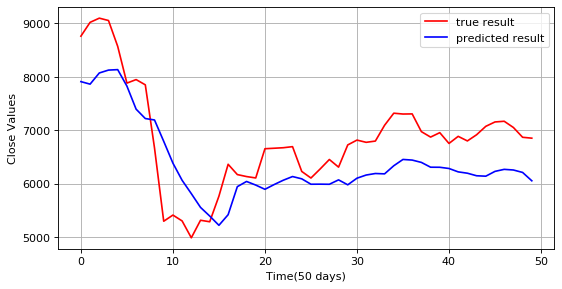

In [14]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
2933/2933 [==============================] - 3s 1ms/step - loss: 0.0056
Epoch 2/100
2933/2933 [==============================] - 3s 1ms/step - loss: 7.2649e-04
Epoch 3/100
2933/2933 [==============================] - 4s 1ms/step - loss: 4.9829e-04
Epoch 4/100
2933/2933 [==============================] - 3s 1ms/step - loss: 3.9128e-04
Epoch 5/100
2933/2933 [==============================] - 3s 1ms/step - loss: 3.1926e-04
Epoch 6/100
2933/2933 [==============================] - 3s 1ms/step - loss: 2.6395e-04
Epoch 7/100
2933/2933 [==============================] - 3s 1ms/step - loss: 2.6979e-04
Epoch 8/100
2933/2933 [==============================] - 3s 1ms/step - loss: 2.3231e-04
Epoch 9/100
2933/2933 [==============================] - 3s 1ms/step - loss: 2.2079e-04
Epoch 10/100
2933/2933 [==============================] - 3s 996us/step - loss: 2.1364e-04
Epoch 11/100
2933/2933 [==============================] - 3s 999us/step - loss: 2.1906e-04
Epoch 12/100
2933/2933 [======

2933/2933 [==============================] - 3s 972us/step - loss: 1.0181e-04
Epoch 93/100
2933/2933 [==============================] - 3s 974us/step - loss: 1.0770e-04
Epoch 94/100
2933/2933 [==============================] - 3s 967us/step - loss: 1.0602e-04
Epoch 95/100
2933/2933 [==============================] - 3s 975us/step - loss: 1.1037e-04
Epoch 96/100
2933/2933 [==============================] - 3s 974us/step - loss: 1.0611e-04
Epoch 97/100
2933/2933 [==============================] - 3s 960us/step - loss: 1.0648e-04
Epoch 98/100
2933/2933 [==============================] - 3s 997us/step - loss: 1.0237e-04
Epoch 99/100
2933/2933 [==============================] - 3s 969us/step - loss: 1.0323e-04
Epoch 100/100
2933/2933 [==============================] - 3s 967us/step - loss: 1.0590e-04


In [16]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [17]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [18]:
predicted_data=model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [19]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

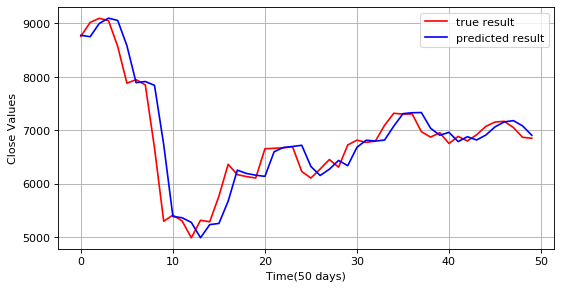

In [20]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()